# English-to-Spanish Machine Translation

This project aims to develop and train a deep learning model to translate text from English into Spanish. The ability to translate text between languages has a wide range of applications, from facilitating communication between people who speak different languages to making information accessible to a larger audience. In this project, we will design and train two sequence-to-sequence models using recurrent neural networks (RNNs) with long short-term memory (LSTM) cells to perform this English-to-Spanish translation task. We will then evaluate and compare their performance.

The dataset used in this project is the Spanish - English sentence pairs dataset from the Tatoeba Project, available at [ManyThings.org](http://www.manythings.org/anki/). This dataset contains 141,543 tab-delimited sentence pairs in English and Spanish, and contains three columns: the English sentence, the Spanish sentence, and the source of the translation.

## Setup

We will begin the project by importing the necessary libraries and modules and by loading the datatset. We will use Keras with TensorFlow to build and train the deep learning models.

In [106]:
# Importing libraries
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Attention, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Loading the dataset
text_file = open('data/spa.txt', 'r')
pairs_lines = text_file.readlines()
text_file.close()

# Converting to a dataframe
pairs_lines = [line.split('\t') for line in pairs_lines]
pairs_df = pd.DataFrame(pairs_lines, columns=['english', 'spanish', 'attribution'])

# Display the dataset shape and the first few rows
print(f"Dataset shape: {pairs_df.shape}")
print()
print("Dataset head:")
print(pairs_df.head())

Dataset shape: (141543, 3)

Dataset head:
  english  spanish                                        attribution
0     Go.      Ve.  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1     Go.    Vete.  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2     Go.    Vaya.  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3     Go.  Váyase.  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4     Hi.    Hola.  CC-BY 2.0 (France) Attribution: tatoeba.org #5...


## Exploratory Data Analysis

We will perform as exploratory data analysis (EDA) to better understand the dataset and its structure and to inform data preprocessing and data modeling. We will begin by displaying a random sample of sentence pairs to get a sense of the data. From there, we will plot the distribution of sentence lengths for both the English and Spanish sentences to understand the data distribution. We will also plot the correlation between English and Spanish sentence lengths to understand their relationship. We will then plot the most common words in the English and Spanish sentences, and finally we will inspect the total vocabulary size for both languages.

In [113]:
# Display 5 random samples
n_samples = 5
print(f"{n_samples} Random Samples:")
for i in range(n_samples):
    # Randomly select a row
    random_row = pairs_df.sample(n=1)
    # Print the English and Spanish sentences
    print(f"English: {random_row['english'].values[0]}")
    print(f"Spanish: {random_row['spanish'].values[0]}")
    print()

5 Random Samples:
English: I don't feel like taking a walk now.
Spanish: Ahora no tengo ganas de dar un paseo.

English: It rained a lot that winter.
Spanish: Llovió mucho aquel invierno.

English: He was born in the 19th century.
Spanish: Él nació en el siglo XIX.

English: Tom needs to do better the next time.
Spanish: Tom necesita hacerlo mejor la próxima vez.

English: Do you bowl?
Spanish: ¿Juegas boliche?



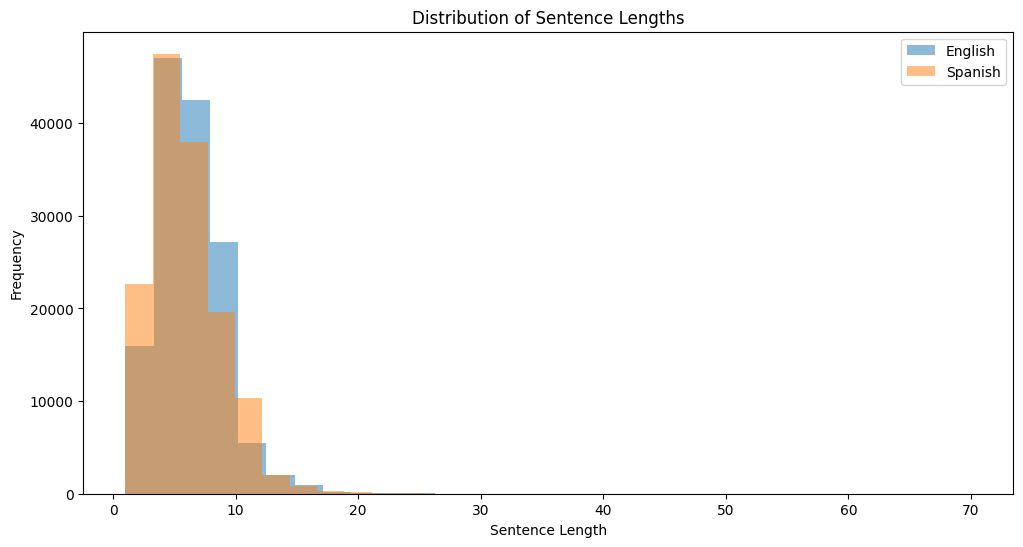

In [114]:
# Plot the distribution of the lengths of the English and Spanish sentences
pairs_df['english_length'] = pairs_df['english'].apply(lambda x: len(x.split()))
pairs_df['spanish_length'] = pairs_df['spanish'].apply(lambda x: len(x.split()))


# Plot the distribution of lengths
plt.figure(figsize=(12, 6))
plt.hist(pairs_df['english_length'], bins=30, alpha=0.5, label='English')
plt.hist(pairs_df['spanish_length'], bins=30, alpha=0.5, label='Spanish')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()

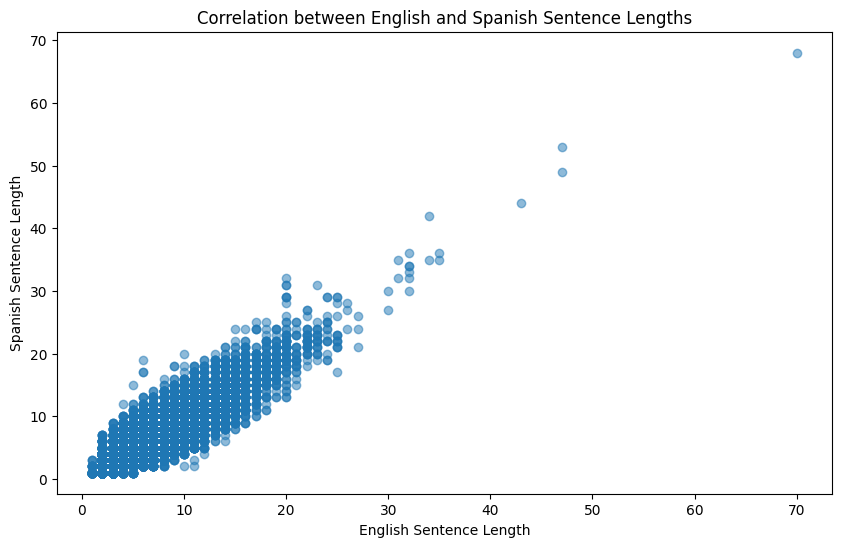

In [115]:
# Plot the correlation between the lengths of the English and Spanish sentences
plt.figure(figsize=(10, 6))
plt.scatter(pairs_df['english_length'], pairs_df['spanish_length'], alpha=0.5)
plt.xlabel('English Sentence Length')
plt.ylabel('Spanish Sentence Length')
plt.title('Correlation between English and Spanish Sentence Lengths')
plt.show()

In [ ]:
# Inspect the 5 longest English sentences
longest_english = pairs_df.nlargest(5, 'english_length')
print("5 Longest English Sentences:")
for index, row in longest_english.iterrows():
    print(f"English: {row['english']}")
    print(f"Spanish: {row['spanish']}")
    print(f"Length: {row['english_length']}")
    print()


5 Longest English Sentences:
English: One day, I woke up to find that God had put hair on my face. I shaved it off. The next day, I found that God had put it back on my face, so I shaved it off again. On the third day, when I found that God had put hair back on my face again, I decided to let God have his way. That's why I have a beard.
Spanish: Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la suya. Por eso tengo barba.
Length: 70

English: If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.
Spanish: Si quieres sonar como un hablante nativo, debes estar di

In [121]:
# Display the top 10 most common words in the English sentences
def plot_top_n_words(df, column, n=10):
    # Split the sentences into words
    words = df[column].str.split(expand=True).stack()
    # Count the frequency of each word
    word_counts = words.value_counts()
    # Get the top 10 most common words
    top_words = word_counts.head(n)
    # Capitalize the column name
    column = column.capitalize()
    # Plot the top 10 most common words
    plt.figure(figsize=(10, 6))
    top_words.plot(kind='bar')
    plt.title(f'Top {n} Most Common Words in {column} Sentences')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

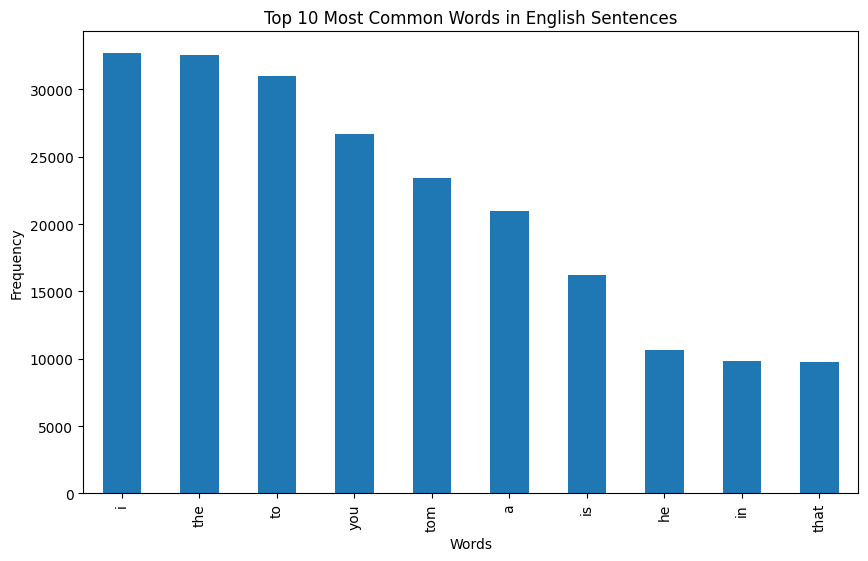

In [122]:
# Plot the top 10 words in the English sentences
plot_top_n_words(pairs_df, 'english')

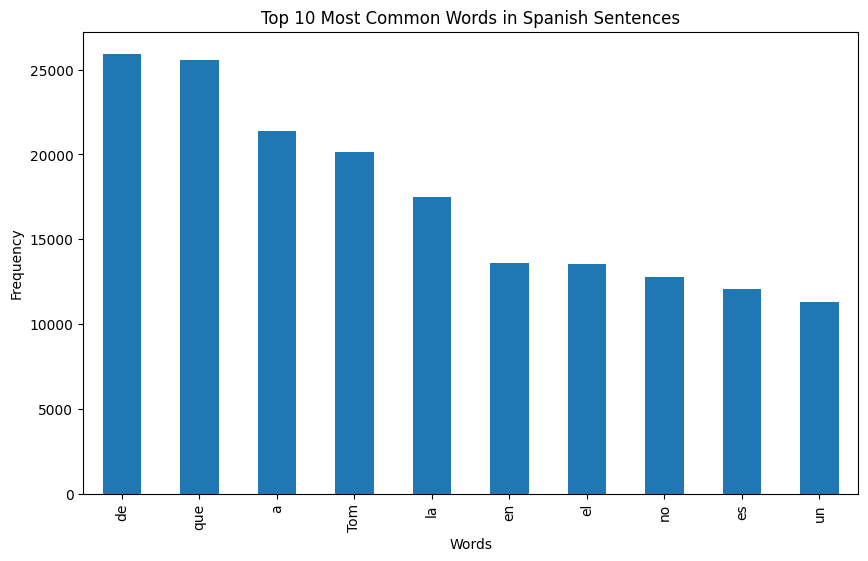

In [ ]:
# Plot the top 10 words in the Spanish sentences
plot_top_n_words(pairs_df, 'spanish')

In [ ]:
# Print the vocabulary size of the English and Spanish sentences
english_words = set()
spanish_words = set()

# Split the sentences into words
for index, row in pairs_df.iterrows():
    english_words.update(row['english'].split())
    spanish_words.update(row['spanish'].split())

print(f"English Vocabulary Size: {len(english_words)}")
print(f"Spanish Vocabulary Size: {len(spanish_words)}")

English Vocabulary Size: 17460
Spanish Vocabulary Size: 32259


## Data Preprocessing

Through the exploratory data analysis, we see that most of the sentences are 20 words or fewer, so we can set a maximum sequence length of 20 words for both the English and Spanish sentences to reduce the complexity of the models. We also see that the total vocabulary size is quite large, so we will limit the corpus to 15,000 unique words for each language. We will also remove punctuation and convert all text to lowercase for both languages so simplify the models further. Finally, we will tokenize the data so that it can be used by the LSTM models. We will split the data into training and validation sets while training the models.

In [119]:
# Preprocessing the data
# Convert to lower case and remove punctuation
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

pairs_df['english'] = pairs_df['english'].str.lower().str.strip(strip_chars)
pairs_df['spanish'] = pairs_df['spanish'].str.lower().str.strip(strip_chars)

# Add start and end token to the Spanish sentences, if they don't already exist
if not pairs_df['spanish'].str.startswith('[start]').any():
    pairs_df['spanish'] = pairs_df['spanish'].apply(lambda x: '[start] ' + x + ' [end]')

# Display the first 5 rows of the dataframe
print("First 5 rows after preprocessing:")
print(pairs_df[['english', 'spanish']].head())

First 5 rows after preprocessing:
  english               spanish
0      go      [start] ve [end]
1      go    [start] vete [end]
2      go    [start] vaya [end]
3      go  [start] váyase [end]
4      hi    [start] hola [end]


In [120]:
# Prepare the data for training
vocab_size = 15000
sequence_length = 20

# Tokenizing the text
tokenizer_eng = Tokenizer(num_words=vocab_size, filters='', lower=False)
tokenizer_eng.fit_on_texts(pairs_df['english'])
tokenizer_spa = Tokenizer(num_words=vocab_size, filters='', lower=False)
tokenizer_spa.fit_on_texts(pairs_df['spanish'])

# Converting the text to sequences
eng_sequences = tokenizer_eng.texts_to_sequences(pairs_df['english'])
spa_sequences = tokenizer_spa.texts_to_sequences(pairs_df['spanish'])

# Padding the sequences
eng_sequences = pad_sequences(eng_sequences, maxlen=sequence_length, padding='post')
spa_sequences = pad_sequences(spa_sequences, maxlen=sequence_length, padding='post')

## Data Modeling

We will develop two models for our English-to-Spanish translation task: a simple model with a single LSTM layer and a more complex sequence-to-sequence model with multiple LSTM layers and attention mechanism. We will train both models on the dataset and evaluate their performance.

### Model 1: Simple LSTM Model

The first model will consist of a single LSTM layer with 128 units. The output layer will be a dense layer with the same number of nodes as the vocabulary size and a softmax activation function. The model will be compiled using the Adam optimizer and the categorical crossentropy loss function.

In [69]:
# Model 1: Simple LSTM
# Define the model
model_1 = Sequential()
model_1.add(Embedding(vocab_size, 64, input_length=sequence_length))
model_1.add(LSTM(128, return_sequences=True))
model_1.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Training the model
epochs = 10
batch_size = 64

# Reshape the target sequences to match the output shape
spa_sequences_1 = np.expand_dims(spa_sequences, -1)

history_1 = model_1.fit(eng_sequences, spa_sequences_1, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 309s 174ms/step - accuracy: 0.5262 - loss: 2.6129 - val_accuracy: 0.2278 - val_loss: 3.1402
Epoch 2/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 304s 172ms/step - accuracy: 0.4406 - loss: 1.5303 - val_accuracy: 0.2356 - val_loss: 2.9133
Epoch 3/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 304s 172ms/step - accuracy: 0.4389 - loss: 1.3248 - val_accuracy: 0.2326 - val_loss: 2.7598
Epoch 4/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 308s 174ms/step - accuracy: 0.4369 - loss: 1.1795 - val_accuracy: 0.2259 - val_loss: 2.6401
Epoch 5/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 307s 173ms/step - accuracy: 0.4366 - loss: 1.0646 - val_accuracy: 0.2315 - val_loss: 2.5877
Epoch 6/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 304s 172ms/step - accuracy: 0.4353 - loss: 0.9736 - val_accuracy: 0.2303 - val_loss: 2.5270
Epoch 7/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 306s 173ms/step - accuracy: 0.4344 - loss: 0.9043 - val_accuracy: 0.2241 - val_loss: 2.4851
Epoch 8/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 305s 172ms/step - ac

In [71]:
# Save the model
model_1.save('models/translation_model_simple.keras')

# Load the model
model_1 = keras.models.load_model('models/translation_model_simple.keras')

### Model 2: Complex LSTM Model

The second model will be a more complex sequence-to-sequence model with an encoder-decoder architecture and an attention mechanism. The encoder will consist of two LSTM layers with 256 units each, and the decoder will also consist of two LSTM layers with 256 units each. The model will use an attention mechanism to focus on different parts of the input sequence when generating the output sequence. The model will be compiled using the Adam optimizer and the categorical crossentropy loss function.

In [ ]:
# Model 2: Complex LSTM Encoder-Decoder with Attention
# Define the encoder
encoder_inputs = Input(shape=(sequence_length,))
encoder_embedding = Embedding(vocab_size, 256)(encoder_inputs)
encoder_lstm1 = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h1, state_c1 = encoder_lstm1(encoder_embedding)
encoder_lstm2 = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h2, state_c2 = encoder_lstm2(encoder_outputs)

# Define the decoder
decoder_inputs = Input(shape=(sequence_length,))
decoder_embedding = Embedding(vocab_size, 256)(decoder_inputs)
decoder_lstm1 = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm1(decoder_embedding, initial_state=[state_h1, state_c1])
decoder_lstm2 = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm2(decoder_outputs, initial_state=[state_h2, state_c2])

# Add attention mechanism
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat = Concatenate()([decoder_outputs, attention])

# Define the output layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

# Define the model
model_2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_2.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 256)   │  3,840,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 256)   │  3,840,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 20, 256), │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 20, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 20, 256), │    525,312 │ lstm[0][0]        │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 20, 256), │    525,312 │ lstm_2[0][0],     │
│                     │ (None, 256),      │            │ lstm_1[0][1],     │
│                     │ (None, 256)]      │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 20, 256)   │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20, 512)   │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 15000) │  7,695,000 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,476,248 (66.67 MB)

 Trainable params: 17,476,248 (66.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the model
epochs = 10
batch_size = 64

history_2 = model_2.fit([eng_sequences, eng_sequences], spa_sequences, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 1053s 594ms/step - accuracy: 0.7272 - loss: 1.9819 - val_accuracy: 0.5595 - val_loss: 2.8230
Epoch 2/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 1045s 590ms/step - accuracy: 0.7880 - loss: 1.1602 - val_accuracy: 0.5895 - val_loss: 2.4157
Epoch 3/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 1030s 582ms/step - accuracy: 0.8171 - loss: 0.8477 - val_accuracy: 0.6018 - val_loss: 2.2521
Epoch 4/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 1031s 582ms/step - accuracy: 0.8339 - loss: 0.6912 - val_accuracy: 0.6092 - val_loss: 2.2332
Epoch 5/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 1025s 579ms/step - accuracy: 0.8495 - loss: 0.5878 - val_accuracy: 0.6106 - val_loss: 2.1993
Epoch 6/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 1042s 588ms/step - accuracy: 0.8616 - loss: 0.5170 - val_accuracy: 0.6097 - val_loss: 2.2121
Epoch 7/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 1047s 591ms/step - accuracy: 0.8712 - loss: 0.4684 - val_accuracy: 0.6106 - val_loss: 2.2684
Epoch 8/10
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 1037s 586ms/s

In [59]:
# Save the model
model_2.save('models/translation_model_complex.keras')

# Load the model
model_2 = keras.models.load_model('models/translation_model_complex.keras')

## Results and Analysis

We will analyze each model by first inspecting the training and validation loss and accuracy across epochs to see how well the models are learning the translation task and whether they're overfitting or underfitting. We will then translate a few English sentences into Spanish and comparing the translations to the actual translations where possible, which will give us a qualitative sense of each model's performance.

### Loss and Accuracy

#### Model 1: Simple LSTM Model

In [76]:
# Define functions to plot accuracy and loss
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

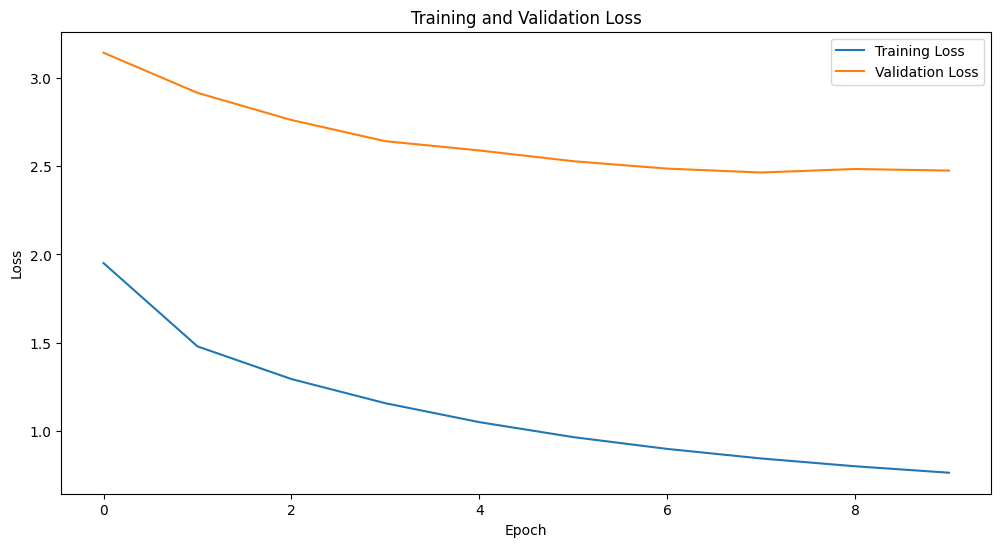

In [79]:
# Plot the loss of Model 1
plot_loss(history_1)

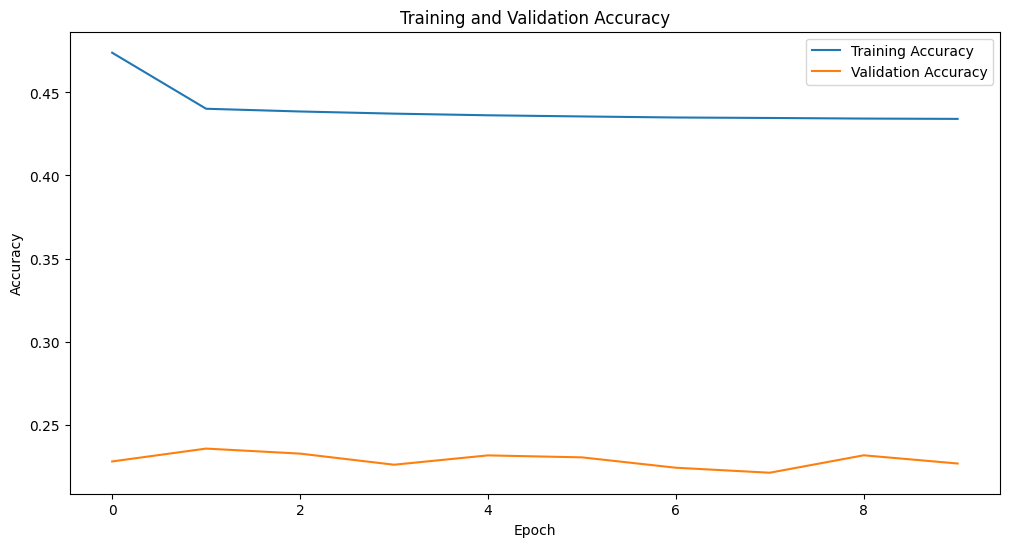

In [80]:
# Plot the accuracy of Model 1
plot_accuracy(history_1)

The simple LSTM model achieved a validation accuracy of 0.2266 and a validation loss of 2.4740 after 10 epochs. The training and validation loss continued to decrease across epochs, indicating that the model was learning the translation task. However, the training and validation accuracy did not improve much across epochs.

#### Model 2: Complex LSTM Model

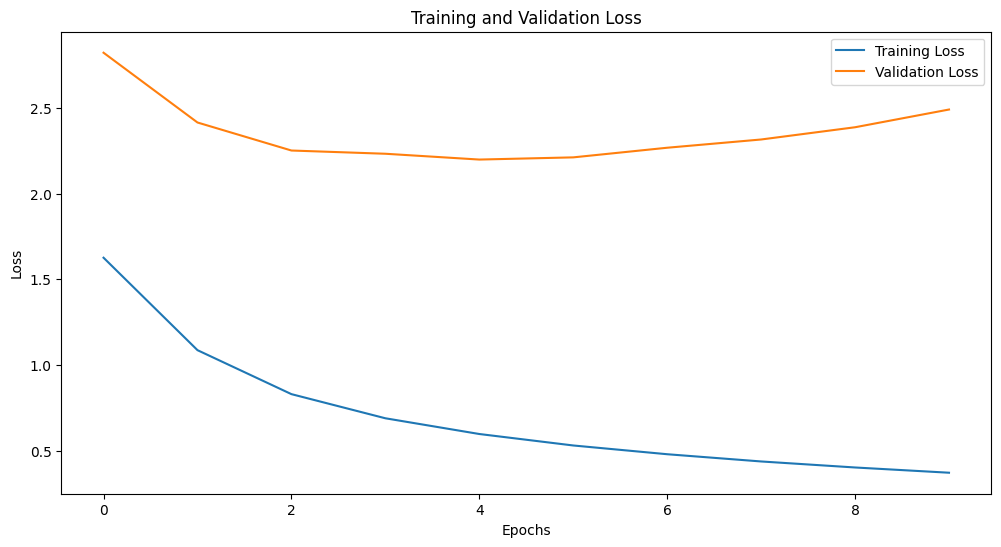

In [ ]:
# Plot the loss of Model 2
plot_loss(history_2)

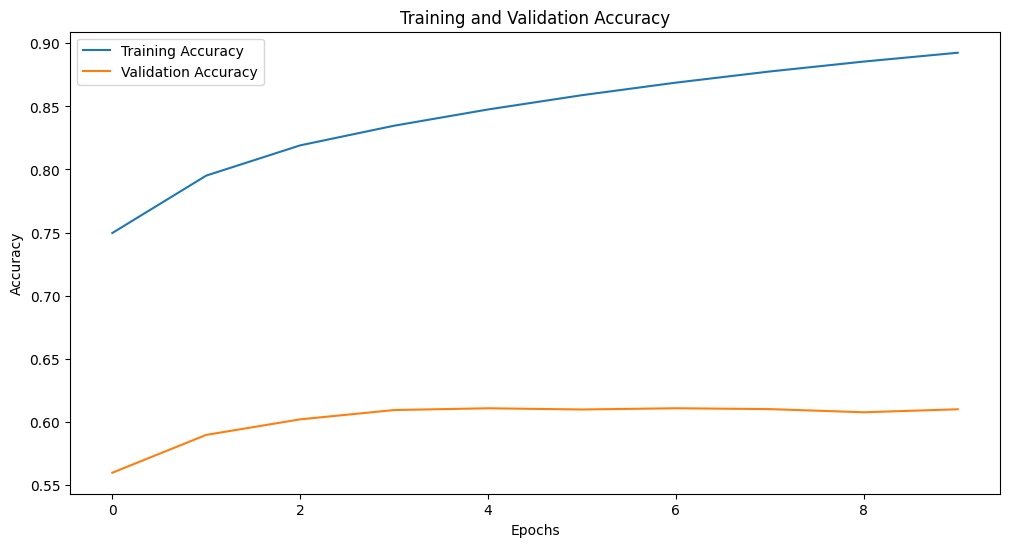

In [ ]:
# Plot the accuracy of Model 2
plot_accuracy(history_2)

The complex LSTM model achieved a validation accuracy of 0.6098 and a validation loss of 2.4914 after 10 epochs. The training and loss continued to decrease across epochs. However, the validation accuracy began to increase after 5 epochs, suggesting that the model was learning the translation task, but might be overfitting the training data. The training accuracy also continued to improve across epochs, although the validation accuracy plateaued after the first few epochs as well.

### Translation Examples

In [103]:
# Define a function to translate a sentence
def translate_sentence(sentence, model="model_1"):
    # Preprocess the sentence, the same way we did for the training data
    # sentence = preprocess_eng(sentence)
    sentence = sentence.lower().strip(strip_chars)
    eng_seq = tokenizer_eng.texts_to_sequences([sentence])
    eng_seq = pad_sequences(eng_seq, maxlen=sequence_length, padding='post')
    # Generate predictions
    try:
        if model == "model_1":
            pred = model_1.predict(eng_seq, verbose=0)
        elif model == "model_2":
            pred = model_2.predict([eng_seq, eng_seq], verbose=0)
        else:
            raise ValueError("Invalid model")
    except Exception as e:
        return str(e)
    # Convert the predictions into word indices
    pred_indices = np.argmax(pred[0], axis=-1)
    # Convert the indices to words
    pred_words = []
    for i in range(sequence_length):
        # Get the word index
        word_index = pred_indices[i]
        # Check if the word is in the tokenizer
        if word_index in tokenizer_spa.index_word:
            # Get the word, add it to the list
            word = tokenizer_spa.index_word[word_index]
            pred_words.append(word)
            # Break loop if the word is the end token
            if word == '[end]':
                break
        # If the word is not in the tokenizer, add a placeholder token
        else:
            pred_words.append('[UNK]')
    return ' '.join(pred_words)

In [104]:
# Generate predictions for 5 randomly selected sentences using Model 1
samples_sentences = df.sample(5)

for i, row in samples_sentences.iterrows():
    eng_sentence = row['english']
    spa_sentence = row['spanish']
    print(f"English: {eng_sentence}")
    print(f"Spanish: {spa_sentence}")
    pred_spa_sentence_1 = translate_sentence(eng_sentence, model="model_1")
    print(f"Model 1 Prediction: {pred_spa_sentence_1}")
    pred_spa_sentence_2 = translate_sentence(eng_sentence, model="model_2")
    print(f"Model 2 Prediction: {pred_spa_sentence_2}")
    print()

English: you're mine
Spanish: [start] usted es mío [end]
Model 1 Prediction: [start] eres eres [end]
Model 2 Prediction: [start] tú es mío [end]

English: these flowers are from our garden
Spanish: [start] estas flores son de nuestro jardín [end]
Model 1 Prediction: [start] estas flores son nuestra nuestro jardín [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
Model 2 Prediction: [start] estas flores son de nuestro jardín [end]

English: no, i wasn't talking to you
Spanish: [start] no, no hablaba yo contigo [end]
Model 1 Prediction: [start] no, no hablando hablando [end]
Model 2 Prediction: [start] no, no hablaba yo hablando [end]

English: will it rain this afternoon
Spanish: [start] va a llover esta tarde [end]
Model 1 Prediction: [start] lloverá mañana?" [end]
Model 2 Prediction: [start] lloverá lloverá llover [end]

English: the place is almost deserted
Spanish: [start] el lugar está casi desierto [end]
Model 1 Prediction: [start] el lugar está casi de

In [105]:
# Test the translation with a few new sentences
test_sentences = [
    "I am a student.",
    "Where is the bathroom?",
    "How much does this beer cost?",
    "I love you.",
    "What is your name?",
    "I am hungry.",
    "How much longer do we have to wait for the food?",
    "I am going to the beach tomorrow.",
    "I am sorry.",
    "I am happy."
]

for sentence in test_sentences:
    print(f"English: {sentence}")
    pred_spa_sentence_1 = translate_sentence(sentence, model="model_1")
    print(f"Model 1 Prediction: {pred_spa_sentence_1}")
    pred_spa_sentence_2 = translate_sentence(sentence, model="model_2")
    print(f"Model 2 Prediction: {pred_spa_sentence_2}")
    print()

English: I am a student.
Model 1 Prediction: [start] estoy un estudiante [end]
Model 2 Prediction: [start] soy un estudiante [end]

English: Where is the bathroom?
Model 1 Prediction: [start] dónde está el baño [end]
Model 2 Prediction: [start] dónde está el servicios [end]

English: How much does this beer cost?
Model 1 Prediction: [start] cuánto cuesta [end]
Model 2 Prediction: [start] cuánto cuesta esta cerveza [end]

English: I love you.
Model 1 Prediction: [start] me amo [end]
Model 2 Prediction: [start] te amo [end]

English: What is your name?
Model 1 Prediction: [start] qué es tu nombre [end]
Model 2 Prediction: [start] cuál es llama [end]

English: I am hungry.
Model 1 Prediction: [start] estoy hambre [end]
Model 2 Prediction: [start] tengo hambriento [end]

English: How much longer do we have to wait for the food?
Model 1 Prediction: [start] cuánto tiempo más [end]
Model 2 Prediction: [start] cuánto tiempo que que que para comida [end]

English: I am going to the beach tomorr

After inspecting the translations of a few English sentences into Spanish, we see some interesting results! Both models are able to generate reasonable translations, however neither model is able to generate accurate translations every time. In general, the complex LSTM model seems to produce more accurate translations than the simple model. Both models seem to have learned the meaning of the words, but the complex model is able to generate translations that are more gramatically correct.

## Conclusion

We have successfully trained two deep learning LSTM models to translate English text into Spanish! The complex LSTM model with an attention mechanism outperformed the simple LSTM model. However, both models were able to generate reasonable translations which demonstrates the incredible capability of sequence-to-sequence models in machine translation tasks.

Future work can consider a number of directions to improve the models built in this project. For example, we can experiment with different model architectures and hyperparameters, including the learning rate, number of units in the LSTM layers, and the number of epochs. We can also experiment with different sequence lengths and tokenized vocabulary sizes. Additionally, we can train these models on a larger dataset and evaluate them with more advanced metrics, like BLEU score, to get a better understanding of their performance. We can also explore using pre-trained models like BERT.

Overall, this project provides a straight-forward foundation for building and training deep learning models for machine translation tasks, and has many ways it can be improved to achieve even better results in the future.

### References
- [ManyThings.org](http://www.manythings.org/anki/)
- [English-to-Spanish translation with a sequence-to-sequence Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)

